In [1]:
import sys
sys.path.append("../")
sys.path.append("../../../assets")

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.backend import clear_session
import bayesflow as beef
import pandas as pd
import pickle

from experiments import NonStationaryDDMExperiment
from models import RandomWalkDDM, MixtureRandomWalkDDM, LevyFlightDDM, RegimeSwitchingDDM

/Users/lukas/opt/miniconda3/envs/beef/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
with open('../data/posteriors/samples_per_model.pkl', 'rb') as file:
    samples_per_model = pickle.load(file)
with open('../data/winning_model_per_person.pkl', 'rb') as file:
    winning_model_per_person = pickle.load(file)

In [3]:
FIT_MODELS = False

NUM_OBS = 768
NUM_SAMPLES = 1000
NUM_RESIMULATIONS = 100

LOCAL_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
LOCAL_PARAM_NAMES  = [r'v', r'a', r'\tau']
HYPER_PARAM_LABELS = ['Transition std. deviation', 'Switch Probability']
HYPER_PARAM_NAMES  = [r'\sigma', r'q']

COMPARISON_COLOR = '#133a76'

FONT_SIZE_1 = 24
FONT_SIZE_2 = 20
FONT_SIZE_3 = 16

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

In [ ]:
rw_ddm = RandomWalkDDM()
rw_ddm_exp = NonStationaryDDMExperiment(
    rw_ddm,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_random_walk_ddm"
    )

mrw_ddm = MixtureRandomWalkDDM()
mrw_ddm_exp = NonStationaryDDMExperiment(
    mrw_ddm,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_mixture_random_walk_ddm"
    )

lf_ddm = LevyFlightDDM()
lf_ddm_exp = NonStationaryDDMExperiment(
    lf_ddm,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_levy_flight_ddm"
    )

rs_ddm = RegimeSwitchingDDM()
rs_ddm_exp = NonStationaryDDMExperiment(
    rs_ddm,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_regime_switching_ddm"
    )

# Inference

In [4]:
data = pd.read_csv('../data/data_color_discrimination.csv')
data['rt'] = np.where(data['correct'] == 0, -data['rt'], data['rt'])

In [5]:
NUM_SUBJECTS = len(np.unique(data['id']))
emp_data = np.zeros((NUM_SUBJECTS, NUM_OBS, 1), dtype=np.float32)
for i in range(NUM_SUBJECTS):
    tmp = data[data['id'] == i+1]
    emp_data[i] = tmp['rt'].to_numpy()[:, np.newaxis]

data['rt'] = np.abs(data['rt'])

In [ ]:
if FIT_MODELS:
    rw_local_samples_z = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
    rw_hyper_samples_z = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 3))
    mrw_local_samples_z = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
    mrw_hyper_samples_z = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 5))
    lf_local_samples_z = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
    lf_hyper_samples_z = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 5))
    rs_local_samples_z = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
    rs_hyper_samples_z = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 3))

    with tf.device('/cpu:0'):
        for i in range(NUM_SUBJECTS):
            clear_session()
            tmp_data = {'summary_conditions': emp_data[i:i+1]}
            # random walk ddm
            samples = rw_ddm_exp.amortizer.sample(tmp_data, NUM_SAMPLES)
            rw_local_samples_z[i] = samples['local_samples']
            rw_hyper_samples_z[i] = samples['global_samples']
            # mixture random walk ddm
            samples = mrw_ddm_exp.amortizer.sample(tmp_data, NUM_SAMPLES)
            mrw_local_samples_z[i] = samples['local_samples']
            mrw_hyper_samples_z[i] = samples['global_samples']
            # levy flight ddm
            samples = lf_ddm_exp.amortizer.sample(tmp_data, NUM_SAMPLES)
            lf_local_samples_z[i] = samples['local_samples']
            lf_hyper_samples_z[i] = samples['global_samples']
            # regime switching ddm
            samples = rs_ddm_exp.amortizer.sample(tmp_data, NUM_SAMPLES)
            rs_local_samples_z[i] = samples['local_samples']
            rs_hyper_samples_z[i] = samples['global_samples']

    rw_local_samples = rw_local_samples_z * rw_ddm.local_prior_stds + rw_ddm.local_prior_means
    rw_hyper_samples = rw_hyper_samples_z * rw_ddm.hyper_prior_std + rw_ddm.hyper_prior_mean
    mrw_local_samples = mrw_local_samples_z * mrw_ddm.local_prior_stds + mrw_ddm.local_prior_means
    mrw_hyper_samples = mrw_hyper_samples_z * mrw_ddm.hyper_prior_std + mrw_ddm.hyper_prior_mean
    lf_local_samples = lf_local_samples_z * lf_ddm.local_prior_stds + lf_ddm.local_prior_means
    lf_hyper_samples = lf_hyper_samples_z * lf_ddm.hyper_prior_std + lf_ddm.hyper_prior_mean
    rs_local_samples = rs_local_samples_z * rs_ddm.local_prior_stds + rs_ddm.local_prior_means
    rs_hyper_samples = rs_hyper_samples_z * rs_ddm.hyper_prior_std + rs_ddm.hyper_prior_mean

    np.save("../data/posteriors/rw_local_samples.npy", rw_local_samples)
    np.save("../data/posteriors/rw_hyper_samples.npy", rw_hyper_samples)
    np.save("../data/posteriors/mrw_local_samples.npy", mrw_local_samples)
    np.save("../data/posteriors/mrw_hyper_samples.npy", mrw_hyper_samples)
    np.save("../data/posteriors/lf_local_samples.npy", lf_local_samples)
    np.save("../data/posteriors/lf_hyper_samples.npy", lf_hyper_samples)
    np.save("../data/posteriors/rs_local_samples.npy", rs_local_samples)
    np.save("../data/posteriors/rs_hyper_samples.npy", rs_hyper_samples)
else:
    rw_local_samples = np.load("../data/posteriors/rw_local_samples.npy")
    rw_hyper_samples = np.load("../data/posteriors/rw_hyper_samples.npy")
    mrw_local_samples = np.load("../data/posteriors/mrw_local_samples.npy")
    mrw_hyper_samples = np.load("../data/posteriors/mrw_hyper_samples.npy")
    lf_local_samples = np.load("../data/posteriors/lf_local_samples.npy")
    lf_hyper_samples = np.load("../data/posteriors/lf_hyper_samples.npy")
    rs_local_samples = np.load("../data/posteriors/rs_local_samples.npy")
    rs_hyper_samples = np.load("../data/posteriors/rs_hyper_samples.npy")

# Parameter Trajectories

In [ ]:
# get person data
which = 6
person_data = data[data['id'] == which + 1]
condition = person_data['speed_condition'].to_numpy()
idx_speed = []
if condition[0] == 1:
    idx_speed.append([0])
    idx_speed.append(np.where(condition[:-1] != condition[1:])[0])
    idx_speed = np.concatenate(idx_speed)
else:
    idx_speed.append(np.where(condition[:-1] != condition[1:])[0])
    idx_speed.append([NUM_OBS])
    idx_speed = np.concatenate(idx_speed)

In [ ]:
# random walk ddm
person_rw_samples = rw_local_samples[which]
rw_post_mean = np.mean(person_rw_samples, axis=1)
rw_post_std = np.std(person_rw_samples, axis=1)
# mixture random walk ddm
person_mrw_samples = mrw_local_samples[which]
mrw_post_mean = np.mean(person_mrw_samples, axis=1)
mrw_post_std = np.std(person_mrw_samples, axis=1)
# levy flight ddm
person_lf_samples = lf_local_samples[which]
lf_post_mean = np.mean(person_lf_samples, axis=1)
lf_post_std = np.std(person_lf_samples, axis=1)
# regime switching ddm
person_rs_samples = rs_local_samples[which]
rs_post_mean = np.mean(person_rs_samples, axis=1)
rs_post_std = np.std(person_rs_samples, axis=1)

In [ ]:
fig, axarr = plt.subplots(3, 1, figsize=(18, 14))
for i, ax in enumerate(axarr.flat):
    # random walk
    ax.fill_between(range(NUM_OBS), rw_post_mean[:, i] - rw_post_std[:, i],
                    rw_post_mean[:, i] + rw_post_std[:, i],
                    color='maroon', alpha=0.3, label="Random walk DDM")
    ax.plot(range(NUM_OBS), rw_post_mean[:, i], color='maroon', alpha=0.8)
    # mixture random walk
    ax.fill_between(range(NUM_OBS), mrw_post_mean[:, i] - mrw_post_std[:, i],
                    mrw_post_mean[:, i] + mrw_post_std[:, i],
                    color=COMPARISON_COLOR, alpha=0.3, label="Mixture random walk DDM")
    ax.plot(range(NUM_OBS), mrw_post_mean[:, i], color=COMPARISON_COLOR, alpha=0.8)
    # # regime switching
    # ax.fill_between(range(NUM_OBS), rs_post_mean[:, i] - rs_post_std[:, i],
    #                 rs_post_mean[:, i] + rs_post_std[:, i],
    #                 color="green", alpha=0.3, label="Regime Switching DDM")
    # ax.plot(range(NUM_OBS), rs_post_mean[:, i], color="green", alpha=0.8)

    # yellow shades
    x = 0
    while x < idx_speed.shape[0]:
        ax.axvspan(idx_speed[x] + 1, idx_speed[x + 1] + 1, alpha=0.2, color='#f0c654', label="Speed condition")
        x = x + 2
    # difficulty manipulation
    if i == 0:
        ax.plot(range(NUM_OBS), (person_data['difficulty'] - 3) * -2, color='black', alpha=0.5, label="Difficulty manipulation")

    # aestehtics
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)
    ax.grid(alpha=0.3)
    time = np.arange(0, 768+1, 48)
    time[0] = 1
    ax.set_xticks(time)
    ax.margins(x=0.01)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    ax.set_ylabel("Parameter\nValue", rotation=0, labelpad=70, fontsize=FONT_SIZE_2)
    if i == 2:
        ax.set_xlabel("Trial", labelpad=20, fontsize=FONT_SIZE_2)
        
sns.despine()
# fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
# legend
handles = [
    Patch(facecolor='maroon', alpha=0.3, edgecolor=None, label="Random walk DDM"),
    Patch(facecolor=COMPARISON_COLOR, alpha=0.3, edgecolor=None, label="Mixture random walk DDM"),
    Patch(facecolor='#f0c654', alpha=0.2, edgecolor=None, label="Speed condition"),
    Line2D(xdata=[], ydata=[], color='black', alpha=0.5, lw=3, label="Difficulty manipulation")
    ]
fig.legend(
    handles,
    ["Random walk DDM", "Mixture random walk DDM", "Speed condition", "Difficulty manipulation"],
    fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.001),
    loc="center", ncol=4
    )
# plt.savefig("../plots/param_dynamics.png", dpi=300, bbox_inches="tight")

# Posterior Re-Simulation

In [ ]:
idx = np.random.choice(np.arange(NUM_SAMPLES), NUM_RESIMULATIONS, replace=False)

In [ ]:
rw_resim_data = np.zeros((NUM_SUBJECTS, NUM_RESIMULATIONS, NUM_OBS))
mrw_resim_data = np.zeros((NUM_SUBJECTS, NUM_RESIMULATIONS, NUM_OBS))
lf_resim_data = np.zeros((NUM_SUBJECTS, NUM_RESIMULATIONS, NUM_OBS))
rs_resim_data = np.zeros((NUM_SUBJECTS, NUM_RESIMULATIONS, NUM_OBS))

rw_samples_t = np.transpose(rw_local_samples, (0, 2, 1, 3))
mrw_samples_t = np.transpose(mrw_local_samples, (0, 2, 1, 3))
lf_samples_t = np.transpose(lf_local_samples, (0, 2, 1, 3))
rs_samples_t = np.transpose(rs_local_samples, (0, 2, 1, 3))
for sub in range(NUM_SUBJECTS):
    rw_resim_data[sub] = rw_ddm.likelihood(rw_samples_t[sub, idx, :, :])['sim_data']
    mrw_resim_data[sub] = mrw_ddm.likelihood(mrw_samples_t[sub, idx, :, :])['sim_data']
    lf_resim_data[sub] = lf_ddm.likelihood(lf_samples_t[sub, idx, :, :])['sim_data']
    rs_resim_data[sub] = rs_ddm.likelihood(rs_samples_t[sub, idx, :, :])['sim_data']

In [ ]:
rt_summary_per_model = []
acc_summary_per_model = []
resim_data_per_model = []
rt_summary_per_model.append(rt_summary)
acc_summary_per_model.append(acc_summary)
for i, model in enumerate(models):
    resim_data = np.zeros((NUM_SUBJECTS, NUM_RESIMULATIONS, NUM_OBS, 6))
    for sub in range(NUM_SUBJECTS):
        # compute indiviudal summaries
        person_data = data.loc[data.id == sub+1]
        # posterior re-simulation for all models
        idx = np.random.choice(np.arange(NUM_SAMPLES), NUM_RESIMULATIONS, replace=False)
        pred_data = model.likelihood(samples_per_model[i]['local_samples'][sub, :, idx, :])['sim_data']
        pred_rt = np.abs(pred_data[:, :, None])
        pred_correct = np.where(np.sign(pred_data) == -1, 0, 1)[:, :, None]
        condition = np.tile(person_data['speed_condition'], (NUM_RESIMULATIONS, 1))[:, :, None]
        difficulty = np.tile(person_data['difficulty'], (NUM_RESIMULATIONS, 1))[:, :, None]
        id = np.full((NUM_RESIMULATIONS, NUM_OBS, 1), sub+1)
        sim_seq = np.repeat(np.arange(NUM_RESIMULATIONS), NUM_OBS).reshape((NUM_RESIMULATIONS, NUM_OBS, 1))
        resim_data[sub] = np.c_[id, sim_seq, pred_rt, pred_correct, condition, difficulty]

    resim_data_per_model.append(resim_data)
    # overall re-simulation
    reshaped_data = resim_data.reshape(-1, 6)
    df = pd.DataFrame(reshaped_data, columns=['id', 'sim', 'rt', 'correct', 'speed_condition', 'difficulty'])
    # summarize rts
    grouped_data = df.groupby(['speed_condition', 'difficulty'])
    summary = grouped_data.agg({
        'rt': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
    })
    summary = summary.reset_index(drop=False)
    summary.columns = ['speed_condition', 'difficulty', 'median', 'mad']
    rt_summary_per_model.append(summary)
    # summarize accuracy
    grouped_data = df.groupby(['id', 'sim', 'speed_condition', 'difficulty'])
    summary = grouped_data.agg({
                'correct': ['mean']
            }).reset_index(drop=False)
    summary.columns = ['id', 'sim', 'speed_condition', 'difficulty', 'accuracy']
    grouped_data = summary.groupby(['speed_condition', 'difficulty'])
    summary = grouped_data.agg({
                'accuracy': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
            }).reset_index(drop=False)
    summary.columns = ['speed_condition', 'difficulty', 'median', 'mad']
    acc_summary_per_model.append(summary)

In [9]:
NUM_OBS = 768
NUM_SAMPLES = 1000
NUM_RESIMULATIONS = 100

LOCAL_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
LOCAL_PARAM_NAMES  = [r'v', r'a', r'\tau']
MODEL_NAMES = [
    'Random walk DDM', 'Mixture random walk DDM',
    'Levy flight DDM', 'Regime switching DDM'
    ]
CONDITION_NAMES = ["Accuracy Condition", "Speed Condition"]
BAR_WIDTH = np.arange(-0.6, 0.7, 0.2)
X_AXIS_VALUES = np.arange(4) * 2
LABELS = [
    'Empiric', 'Random walk', 'Mixture random walk',
    'Levy flight', 'Regime switching'
    ]
COLORS = [
    "black", "orange", "maroon", "#133a76", "green"
]
FONT_SIZE_0 = 26
FONT_SIZE_1 = 24
FONT_SIZE_2 = 20
FONT_SIZE_3 = 16

In [ ]:
NUM_OBS = 768
NUM_SAMPLES = 1000
NUM_RESIMULATIONS = 100

LOCAL_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
LOCAL_PARAM_NAMES  = [r'v', r'a', r'\tau']
MODEL_NAMES = [
    'Random walk DDM', 'Mixture random walk DDM',
    'Levy flight DDM', 'Regime switching DDM'
    ]
CONDITION_NAMES = ["Accuracy Condition", "Speed Condition"]
BAR_WIDTH = np.arange(-0.6, 0.7, 0.2)
X_AXIS_VALUES = np.arange(4)  * 2
LABELS = [
    'Empiric', 'Random walk', 'Mixture random walk',
    'Levy flight', 'Regime switching'
    ]
COLORS = [
    "black", "orange", "maroon", "#133a76", "green"
]
FONT_SIZE_0 = 26
FONT_SIZE_1 = 24
FONT_SIZE_2 = 20
FONT_SIZE_3 = 16

In [ ]:
def plot_result_summary(summaries, ylabel, ylim=None, figsize=(16, 6)):
    handles = []
    fig, axarr = plt.subplots(1, 2, figsize=figsize)
    for i, ax in enumerate(axarr.flat):
        for t, summary in enumerate(summaries):
            ax.scatter(
                X_AXIS_VALUES + BAR_WIDTH[t],
                summary.loc[summary.speed_condition == i, 'point_estimate'],
                s=75, color=COLORS[t], label=LABELS[t]
            )
            ax.errorbar(
                X_AXIS_VALUES + BAR_WIDTH[t],
                summary.loc[summary.speed_condition == i, 'point_estimate'],
                yerr=summary.loc[summary.speed_condition == i, 'error'],
                # fmt='none', capsize=5, elinewidth=2,
                # color=COLORS[t]
                fmt='o', color=COLORS[t], markersize=8, elinewidth=2, capsize=0
                )
            handles.append(
                Line2D(
                    xdata=[], ydata=[], marker='o', markersize=10, lw=3,
                    color=COLORS[t], label=LABELS[t]
                )
            )
        ax.set_title(CONDITION_NAMES[i], fontsize=FONT_SIZE_1)
        x_labels = ['1', '2', '3', '4']
        x_positions = X_AXIS_VALUES
        ax.set_xticks(x_positions, x_labels)
        if ylim == None:
            ax.set_ylim([
                summaries[0]["point_estimate"].min() - 0.1,
                summaries[0]["point_estimate"].max() + 0.4
                ])
        else:
            ax.set_ylim(ylim)
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
        if i == 0:
            ax.set_ylabel(ylabel, labelpad=10, fontsize=FONT_SIZE_2)
        ax.set_xlabel("Difficulty", labelpad=10, fontsize=FONT_SIZE_2)
    # legend
    fig.subplots_adjust(hspace=0.5)
    fig.legend(
        handles,
        LABELS,
        fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05),
        loc="center", ncol=5
        )
    sns.despine()
    fig.tight_layout()
    return fig

In [ ]:
# compute overall empiric rt summaries
grouped_data = data.groupby(['speed_condition', 'difficulty'])
rt_summary = grouped_data.agg({
            'rt': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
        }).reset_index(drop=False)
rt_summary.columns = ['speed_condition', 'difficulty', 'median', 'mad']
# compute overall empiric acc summaries
grouped_data = data.groupby(['id', 'speed_condition', 'difficulty'])
acc_summary = grouped_data.agg({
            'correct': ['mean']
        }).reset_index(drop=False)
acc_summary.columns = ['id', 'speed_condition', 'difficulty', 'accuracy']
grouped_data = acc_summary.groupby(['speed_condition', 'difficulty'])
acc_summary = grouped_data.agg({
            'accuracy': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
        }).reset_index(drop=False)
acc_summary.columns = ['speed_condition', 'difficulty', 'median', 'mad']
# iterate over model and subjects
rt_summary_per_model = []
acc_summary_per_model = []
resim_data_per_model = []
rt_summary_per_model.append(rt_summary)
acc_summary_per_model.append(acc_summary)
for i, model in enumerate(models):
    resim_data = np.zeros((NUM_SUBJECTS, NUM_RESIMULATIONS, NUM_OBS, 6))
    for sub in range(NUM_SUBJECTS):
        # compute indiviudal summaries
        person_data = data.loc[data.id == sub+1]
        # parameter trajectory of winning model
        winning_model = winning_model_per_person[sub]
        local_samples = samples_per_model[winning_model]['local_samples'][sub]
        # posterior re-simulation for all models
        idx = np.random.choice(np.arange(NUM_SAMPLES), NUM_RESIMULATIONS, replace=False)
        pred_data = model.likelihood(samples_per_model[i]['local_samples'][sub, :, idx, :])['sim_data']
        pred_rt = np.abs(pred_data[:, :, None])
        pred_correct = np.where(np.sign(pred_data) == -1, 0, 1)[:, :, None]
        condition = np.tile(person_data['speed_condition'], (NUM_RESIMULATIONS, 1))[:, :, None]
        difficulty = np.tile(person_data['difficulty'], (NUM_RESIMULATIONS, 1))[:, :, None]
        id = np.full((NUM_RESIMULATIONS, NUM_OBS, 1), sub+1)
        sim_seq = np.repeat(np.arange(NUM_RESIMULATIONS), NUM_OBS).reshape((NUM_RESIMULATIONS, NUM_OBS, 1))
        resim_data[sub] = np.c_[id, sim_seq, pred_rt, pred_correct, condition, difficulty]

    resim_data_per_model.append(resim_data)

In [ ]:
person_data = data.loc[data.id == sub+1]
grouped = person_data.groupby(['speed_condition', 'difficulty'])
person_summary = grouped.agg({
    'rt': ['median', lambda x: np.median(np.abs(x - np.median(x)))],
    'correct': ['mean', 'std']
}).reset_index(drop=False)
person_summary.columns = ['speed_condition', 'difficulty', 'rt_median', 'rt_mad', 'acc_mean', 'acc_std']
person_rt_summary = person_summary[['speed_condition', 'difficulty', 'rt_median', 'rt_mad']]
person_rt_summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
person_acc_summary = person_summary[['speed_condition', 'difficulty', 'acc_mean', 'acc_std']]
person_acc_summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
person_acc_summary.loc[:, 'error'] = 0
rt_summaries = []
acc_summaries = []
rt_summaries.append(person_rt_summary)
acc_summaries.append(person_acc_summary)
for i in range(len(models)):
    temp_data = resim_data_per_model[i][sub]
    reshaped_data = temp_data.reshape(-1, 6)
    df = pd.DataFrame(reshaped_data, columns=['id', 'sim', 'rt', 'correct', 'speed_condition', 'difficulty'])
    # summarize rt
    grouped_data = df.groupby(['speed_condition', 'difficulty'])
    summary = grouped_data.agg({
        'rt': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
    }).reset_index(drop=False)
    summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
    rt_summaries.append(summary)
    # summarize acc
    grouped_data = df.groupby(['sim', 'speed_condition', 'difficulty'])
    summary = grouped_data.agg({
        'correct': ['mean']
    }).reset_index(drop=False)
    summary.columns = ['sim', 'speed_condition', 'difficulty', 'accuracy']
    grouped_data = summary.groupby(['speed_condition', 'difficulty'])
    summary = grouped_data.agg({
                'accuracy': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
            }).reset_index(drop=False)
    summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
    acc_summaries.append(summary)

In [ ]:
BAR_WIDTH = np.arange(-0.5, 0.7, 0.25)
X_AXIS_VALUES = np.arange(4) * 1.5
BAR_WIDTH

In [ ]:
f = plot_result_summary(acc_summaries, "Accuracy", ylim=[0.5, 1.1], figsize=(10, 4))

In [ ]:
f = plot_result_summary(rt_summaries, "Response time (s)")
f.savefig(f"plots/post_resimulation_rt_{sub+1}.pdf", dpi=300, bbox_inches="tight")
f = plot_result_summary(acc_summaries, "Accuracy")
f.savefig(f"plots/post_resimulation_accuracy_{sub+1}.pdf", dpi=300, bbox_inches="tight")

In [ ]:
with open('../data/posteriors/samples_per_model.pkl', 'rb') as file:
    samples_per_model = pickle.load(file)
with open('../data/winning_model_per_person.pkl', 'rb') as file:
    winning_model_per_person = pickle.load(file)

In [ ]:
# compute overall empiric rt summaries
grouped_data = data.groupby(['speed_condition', 'difficulty'])
rt_summary = grouped_data.agg({
    'rt': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
}).reset_index(drop=False)
rt_summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
# compute overall empiric acc summaries
grouped_data = data.groupby(['id', 'speed_condition', 'difficulty'])
acc_summary = grouped_data.agg({
    'correct': ['mean']
}).reset_index(drop=False)
acc_summary.columns = ['id', 'speed_condition', 'difficulty', 'accuracy']
grouped_data = acc_summary.groupby(['speed_condition', 'difficulty'])
acc_summary = grouped_data.agg({
    'accuracy': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
}).reset_index(drop=False)
acc_summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
# iterate over model and subjects
rt_summary_per_model = []
acc_summary_per_model = []
resim_data_per_model = []
posteriors_per_model = []
rt_summary_per_model.append(rt_summary)
acc_summary_per_model.append(acc_summary)
for i, model in enumerate(models):
    resim_data = np.zeros((NUM_SUBJECTS, NUM_RESIMULATIONS, NUM_OBS, 6))
    person_samples = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 5))
    for sub in range(NUM_SUBJECTS):
        # compute indiviudal summaries
        person_data = data.loc[data.id == sub+1]
        # posterior re-simulation for all models
        idx = np.random.choice(np.arange(NUM_SAMPLES), NUM_RESIMULATIONS, replace=False)
        pred_data = model.likelihood(samples_per_model[i]['local_samples'][sub, :, idx, :])['sim_data']
        pred_rt = np.abs(pred_data[:, :, None])
        pred_correct = np.where(np.sign(pred_data) == -1, 0, 1)[:, :, None]
        condition = np.tile(person_data['speed_condition'], (NUM_RESIMULATIONS, 1))[:, :, None]
        difficulty = np.tile(person_data['difficulty'], (NUM_RESIMULATIONS, 1))[:, :, None]
        id = np.full((NUM_RESIMULATIONS, NUM_OBS, 1), sub+1)
        sim_seq = np.repeat(np.arange(NUM_RESIMULATIONS), NUM_OBS).reshape((NUM_RESIMULATIONS, NUM_OBS, 1))
        resim_data[sub] = np.c_[id, sim_seq, pred_rt, pred_correct, condition, difficulty]

    resim_data_per_model.append(resim_data)
    # overall re-simulation
    reshaped_data = resim_data.reshape(-1, 6)
    df = pd.DataFrame(reshaped_data, columns=['id', 'sim', 'rt', 'correct', 'speed_condition', 'difficulty'])
    # summarize rts
    grouped_data = df.groupby(['speed_condition', 'difficulty'])
    summary = grouped_data.agg({
        'rt': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
    })
    summary = summary.reset_index(drop=False)
    summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
    rt_summary_per_model.append(summary)
    # summarize accuracy
    grouped_data = df.groupby(['id', 'sim', 'speed_condition', 'difficulty'])
    summary = grouped_data.agg({
        'correct': ['mean']
    }).reset_index(drop=False)
    summary.columns = ['id', 'sim', 'speed_condition', 'difficulty', 'accuracy']
    grouped_data = summary.groupby(['speed_condition', 'difficulty'])
    summary = grouped_data.agg({
        'accuracy': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
    }).reset_index(drop=False)
    summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
    acc_summary_per_model.append(summary)

In [ ]:
v_summary_per_model = []
a_summary_per_model = []
for i, model in enumerate(models):
    samples = samples_per_model[i]['local_samples']
    difficulty = data.difficulty.to_numpy().reshape((14, NUM_OBS, 1))
    difficulty = np.repeat(difficulty, 2000, axis=2)[:, :, :, np.newaxis]
    condition = data.speed_condition.to_numpy().reshape((14, NUM_OBS, 1))
    condition = np.repeat(condition, 2000, axis=2)[:, :, :, np.newaxis]
    samples = np.c_[condition, difficulty, samples]

    reshaped_data = samples.reshape(-1, 5)
    df = pd.DataFrame(reshaped_data, columns=['speed_condition', 'difficulty', 'v', 'a', 'tau'])
    grouped_data = df.groupby(['speed_condition', 'difficulty'])
    summary = grouped_data.agg({
        'v': ['median', lambda x: np.median(np.abs(x - np.median(x)))],
        'a': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
    }).reset_index(drop=False)
    summary.columns = ['speed_condition', 'difficulty', 'v_median', 'v_mad', 'a_median', 'a_mad']
    v_summary = summary[['speed_condition', 'difficulty', 'v_median', 'v_mad']]
    v_summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
    a_summary = summary[['speed_condition', 'difficulty', 'a_median', 'a_mad']]
    a_summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
    v_summary_per_model.append(v_summary)
    a_summary_per_model.append(a_summary)

In [ ]:
summary_list = [rt_summary_per_model, acc_summary_per_model, v_summary_per_model, a_summary_per_model]

In [ ]:
# individual

In [ ]:
i = 0
local_samples = samples_per_model[i]['local_samples'][sub].transpose((1, 0, 2))
speed_condition = np.tile(person_data['speed_condition'].to_numpy()[:, None], (2000, 1, 1))
difficulty = np.tile(person_data['difficulty'].to_numpy()[:, None], (2000, 1, 1))
post_samples = np.c_[speed_condition, difficulty, local_samples]
reshaped_data = post_samples.reshape(-1, 5)
df = pd.DataFrame(reshaped_data, columns=['speed_condition', 'difficulty', 'v', 'a', 'tau'])
grouped_data = df.groupby(['speed_condition', 'difficulty'])
summary = grouped_data.agg({
    'v': ['median', lambda x: np.median(np.abs(x - np.median(x)))],
    'a': ['median', lambda x: np.median(np.abs(x - np.median(x)))]
})
summary = summary.reset_index(drop=False)
summary.columns = ['speed_condition', 'difficulty', 'v_median', 'v_mad', 'a_median', 'a_mad']
v_summary = summary[['speed_condition', 'difficulty', 'v_median', 'v_mad']]
v_summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
a_summary = summary[['speed_condition', 'difficulty', 'a_median', 'a_mad']]
a_summary.columns = ['speed_condition', 'difficulty', 'point_estimate', 'error']
v_summaries.append(v_summary)
a_summaries.append(a_summary)

In [ ]:
a_summary

In [ ]:
YLABEL = ["Response time (s)", "Response time (s)", "Accuracy", "Accuracy", "Drift rate", "Drift rate", "Threshold", "Threshold"]
BAR_WIDTH = np.arange(-0.5, 0.7, 0.25)

In [ ]:
def plot_result_summary(summaries, figsize=(18, 8)):
    handles = []
    fig, axarr = plt.subplots(2, 4, figsize=figsize)
    which_summary = np.repeat(np.arange(4), 2)
    which_condition = np.tile([0, 1], 4)
    for i, ax in enumerate(axarr.flat):
        summary = summaries[which_summary[i]]
        if i < 4:
            colors = ["black", "orange", "maroon", "#133a76", "green"]
        else:
            colors = ["orange", "maroon", "#133a76", "green"]
        for t, sumsum in enumerate(summary):
            ax.scatter(
                X_AXIS_VALUES + BAR_WIDTH[t],
                sumsum.loc[sumsum.speed_condition == which_condition[i], 'point_estimate'],
                s=75, color=colors[t], label=LABELS[t]
            )
            ax.errorbar(
                X_AXIS_VALUES + BAR_WIDTH[t],
                sumsum.loc[sumsum.speed_condition == which_condition[i], 'point_estimate'],
                yerr=sumsum.loc[sumsum.speed_condition == which_condition[i], 'error'],
                fmt='o', color=colors[t], markersize=8, elinewidth=2, capsize=0
                )
            handles.append(
                Line2D(
                    xdata=[], ydata=[], marker='o', markersize=10, lw=3,
                    color=colors[t], label=LABELS[t]
                )
            )
        ax.set_title(CONDITION_NAMES[which_condition[i]], pad=20, fontsize=FONT_SIZE_1)
        x_labels = ['1', '2', '3', '4']
        x_positions = X_AXIS_VALUES
        ax.set_xticks(x_positions, x_labels)
        if i < 2:
            # ax.set_ylim([0.35, 1.1])
            ax.set_ylim([
                summary[0]["point_estimate"].min() - 0.1,
                summary[0]["point_estimate"].max() + 0.4
                ])
        elif i < 4:
            ax.set_ylim([0.5, 1.05])
        elif i < 6:
            # ax.set_ylim([0.0, 6])
            ax.set_ylim([
                summary[0]["point_estimate"].min() - 1.0,
                summary[0]["point_estimate"].max() + 2.5
                ])
        else:
            # ax.set_ylim([0.75, 1.6])
            ax.set_ylim([
                summary[0]["point_estimate"].min() - 0.25,
                summary[0]["point_estimate"].max() + 0.4
                ])
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
        ax.set_ylabel(YLABEL[i], labelpad=10, fontsize=FONT_SIZE_2)
        if i > 3:
            ax.set_xlabel("Difficulty", labelpad=10, fontsize=FONT_SIZE_2)
        ax.grid(alpha=0.4)
    # legend
    fig.subplots_adjust(hspace=0.5)
    fig.legend(
        handles,
        LABELS,
        fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05),
        loc="center", ncol=5
        )
    sns.despine()
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    return fig

In [ ]:
f = plot_result_summary(summary_list)

In [6]:
from scipy.stats import median_abs_deviation
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

In [10]:
person_data = [data.loc[data.id == 11], data.loc[data.id == 6]]
# parameter trajectory of winning model
winning_model = [winning_model_per_person[10], winning_model_per_person[5]]
local_samples = [
    samples_per_model[winning_model[0]]['local_samples'][10],
    samples_per_model[winning_model[1]]['local_samples'][5]
    ]
FONT_SIZE_1 = 24 + 2
FONT_SIZE_2 = 20 + 2
FONT_SIZE_3 = 18 + 2
# get conditions
condition_1 = person_data[0]['speed_condition'].to_numpy()
idx_speed_1 = []
if condition_1[0] == 1:
    idx_speed_1.append([0])
    idx_speed_1.append(np.where(condition_1[:-1] != condition_1[1:])[0])
    idx_speed_1 = np.concatenate(idx_speed_1)
else:
    idx_speed_1.append(np.where(condition_1[:-1] != condition_1[1:])[0])
    idx_speed_1.append([NUM_OBS])
    idx_speed_1 = np.concatenate(idx_speed_1)
condition_2 = person_data[1]['speed_condition'].to_numpy()
idx_speed_2 = []
if condition_2[0] == 1:
    idx_speed_2.append([0])
    idx_speed_2.append(np.where(condition_2[:-1] != condition_2[1:])[0])
    idx_speed_2 = np.concatenate(idx_speed_2)
else:
    idx_speed_2.append(np.where(condition_2[:-1] != condition_2[1:])[0])
    idx_speed_2.append([NUM_OBS])
    idx_speed_2 = np.concatenate(idx_speed_2)
# calculate posterior median and mad
post_median = [np.median(local_samples[0], axis=1), np.median(local_samples[1], axis=1)]
post_mad = [median_abs_deviation(local_samples[0], axis=1), median_abs_deviation(local_samples[1], axis=1)]

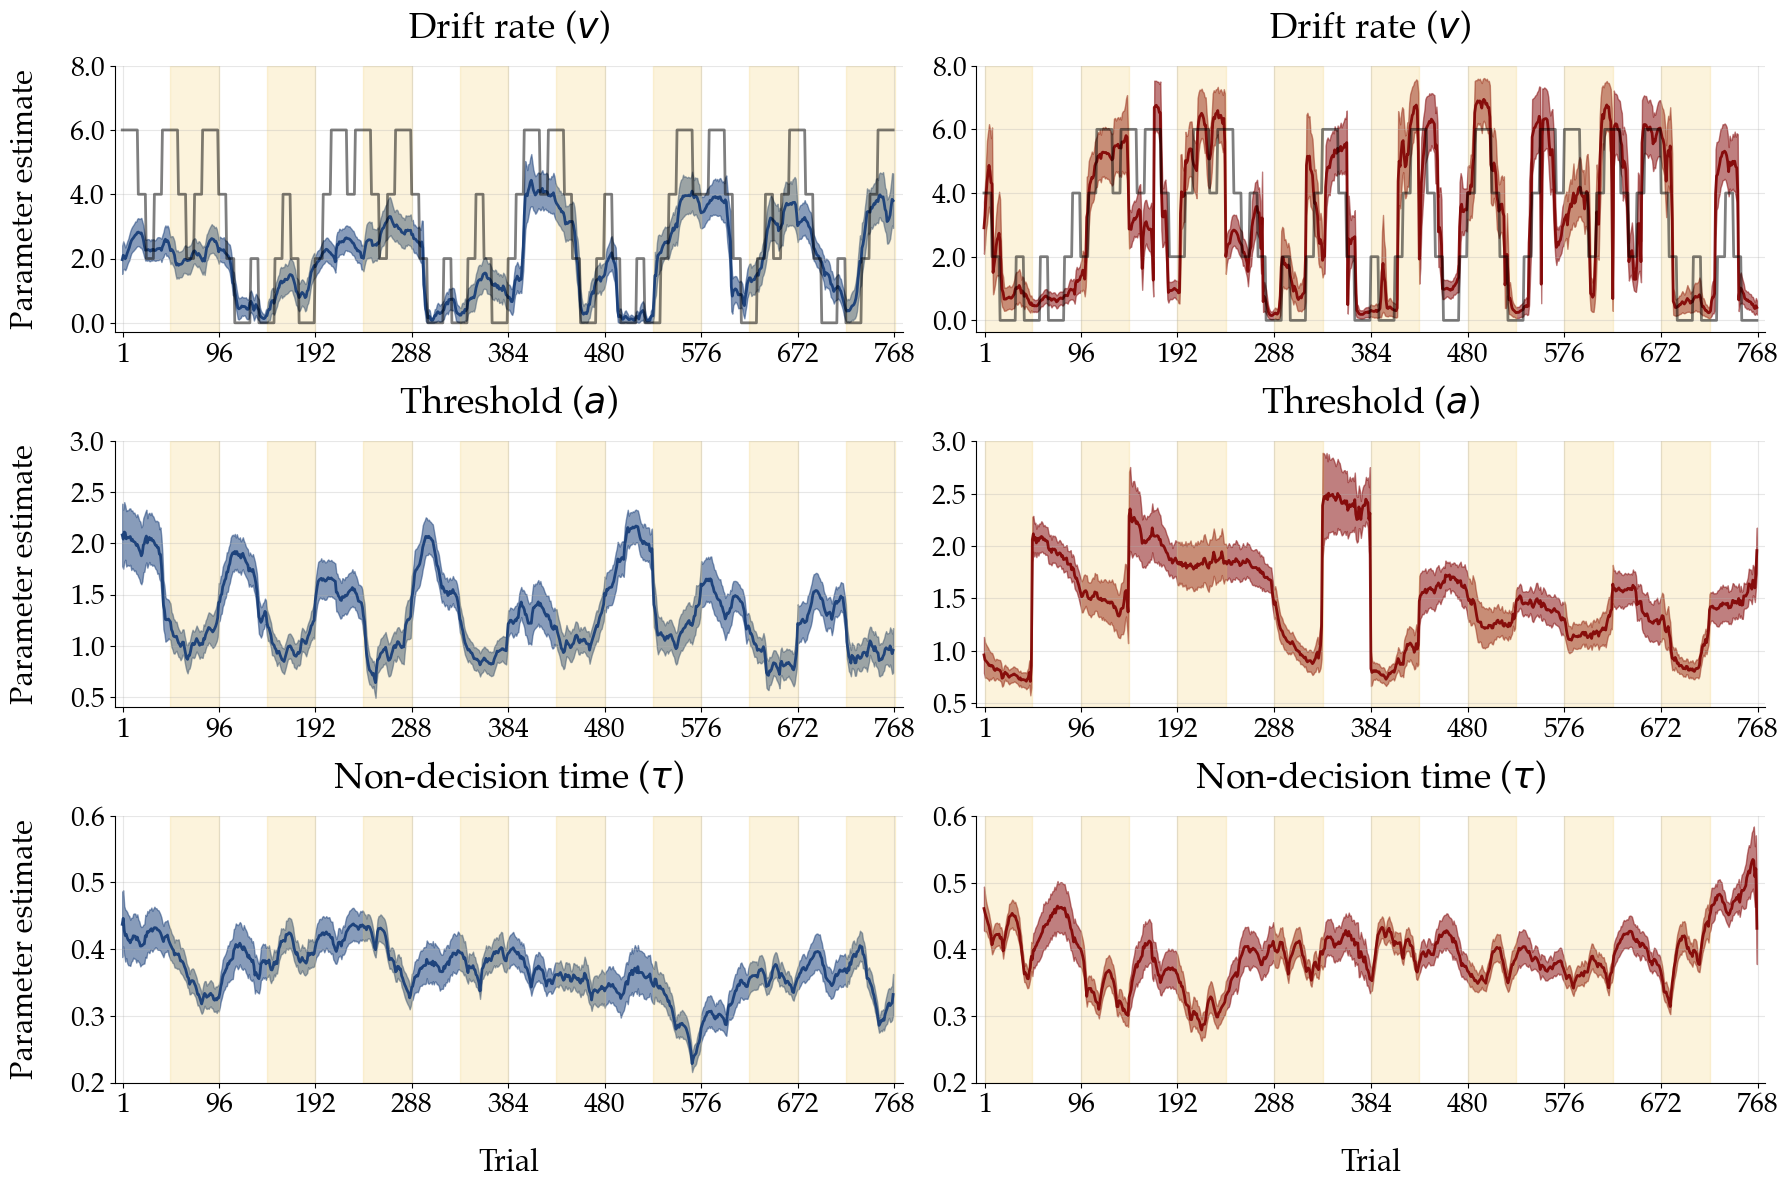

In [17]:
FONT_SIZE_1 = 24 + 2
FONT_SIZE_2 = 20 + 2
FONT_SIZE_3 = 18 + 2
# get conditions
condition_1 = person_data[0]['speed_condition'].to_numpy()
idx_speed_1 = []
if condition_1[0] == 1:
    idx_speed_1.append([0])
    idx_speed_1.append(np.where(condition_1[:-1] != condition_1[1:])[0])
    idx_speed_1 = np.concatenate(idx_speed_1)
else:
    idx_speed_1.append(np.where(condition_1[:-1] != condition_1[1:])[0])
    idx_speed_1.append([NUM_OBS])
    idx_speed_1 = np.concatenate(idx_speed_1)
condition_2 = person_data[1]['speed_condition'].to_numpy()
idx_speed_2 = []
if condition_2[0] == 1:
    idx_speed_2.append([0])
    idx_speed_2.append(np.where(condition_2[:-1] != condition_2[1:])[0])
    idx_speed_2 = np.concatenate(idx_speed_2)
else:
    idx_speed_2.append(np.where(condition_2[:-1] != condition_2[1:])[0])
    idx_speed_2.append([NUM_OBS])
    idx_speed_2 = np.concatenate(idx_speed_2)
# calculate posterior median and mad
post_median = [np.median(local_samples[0], axis=1), np.median(local_samples[1], axis=1)]
post_mad = [median_abs_deviation(local_samples[0], axis=1), median_abs_deviation(local_samples[1], axis=1)]
# plot
Y_TICKS = [
    [8.0, 6.0, 4.0, 2.0, 0.0], [8.0, 6.0, 4.0, 2.0, 0.0],
    [3.0, 2.5, 2.0, 1.5, 1.0, 0.5], [3.0, 2.5, 2.0, 1.5, 1.0, 0.5],
    [0.6, 0.5, 0.4, 0.3, 0.2], [0.6, 0.5, 0.4, 0.3, 0.2]
    ]
Y_TICKS_LABELS = [
    ['8.0', '6.0', '4.0', '2.0', '0.0'], ['8.0', '6.0', '4.0', '2.0', '0.0'],
    ['3.0', '2.5', '2.0', '1.5', '1.0', '0.5'], ['3.0', '2.5', '2.0', '1.5', '1.0', '0.5'],
    ['0.6', '0.5', '0.4', '0.3', '0.2'], ['0.6', '0.5', '0.4', '0.3', '0.2']
    ]
fig, axarr = plt.subplots(3, 2, figsize=(18, 12))
for i, ax in enumerate(axarr.flat):
    if i == 0 or i == 2 or i == 4:
        ax.plot(
            range(NUM_OBS),
            post_median[0][:, int(i/2)], 
            color=COLORS[winning_model[0]+1], alpha=0.9, lw=2, label="Posterior median"
            )
        ax.fill_between(
            range(NUM_OBS),
            post_median[0][:, int(i/2)] - post_mad[0][:, int(i/2)],
            post_median[0][:, int(i/2)] + post_mad[0][:, int(i/2)],
            color=COLORS[winning_model[0]+1], alpha=0.5, label="Posterior MAD"
            )
        # yellow shades
        x = 0
        while x < idx_speed_1.shape[0]:
            ax.axvspan(idx_speed_1[x] + 1, idx_speed_1[x + 1] + 1, alpha=0.2, color='#f0c654', label="Speed condition")
            x = x + 2
        # difficulty manipulation
        if i == 0:
            ax.plot(
                range(NUM_OBS),
                (person_data[0]['difficulty'] - 3) * -2,
                color='black', alpha=0.5, lw=2, label="Difficulty manipulation"
            )
        # aestehtics
        ax.set_title(f'{LOCAL_PARAM_LABELS[int(i/2)]} (${LOCAL_PARAM_NAMES[int(i/2)]}$)', fontsize=FONT_SIZE_1, pad=20)
        ax.grid(alpha=0.3)
        time = np.arange(0, 768+1, 96)
        time[0] = 1
        ax.set_xticks(time)
        ax.margins(x=0.01)
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
        ax.set_ylabel("Parameter estimate", labelpad=20, fontsize=FONT_SIZE_2)
    else:
        ax.plot(
            range(NUM_OBS),
            post_median[1][:, int((i-1)/2)], 
            color=COLORS[winning_model[1]+1], alpha=0.9, lw=2, label="Posterior median"
            )
        ax.fill_between(
            range(NUM_OBS),
            post_median[1][:, int((i-1)/2)] - post_mad[1][:, int((i-1)/2)],
            post_median[1][:, int((i-1)/2)] + post_mad[1][:, int((i-1)/2)],
            color=COLORS[winning_model[1]+1], alpha=0.5, label="Posterior MAD"
            )
        # yellow shades
        x = 0
        while x < idx_speed_2.shape[0]:
            ax.axvspan(idx_speed_2[x] + 1, idx_speed_2[x + 1] + 1, alpha=0.2, color='#f0c654', label="Speed condition")
            x = x + 2
        # difficulty manipulation
        if i == 1:
            ax.plot(
                range(NUM_OBS),
                (person_data[1]['difficulty'] - 3) * -2,
                color='black', alpha=0.5, lw=2, label="Difficulty manipulation"
            )
        # aestehtics
        ax.set_title(f'{LOCAL_PARAM_LABELS[int((i-1)/2)]} (${LOCAL_PARAM_NAMES[int((i-1)/2)]}$)', fontsize=FONT_SIZE_1, pad=20)
        ax.grid(alpha=0.3)
        time = np.arange(0, 768+1, 96)
        time[0] = 1
        ax.set_xticks(time)
        ax.margins(x=0.01)
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 4 or i == 5:
        ax.set_xlabel("Trial", labelpad=20, fontsize=FONT_SIZE_2)
    ax.set_yticks(Y_TICKS[i], labels=Y_TICKS_LABELS[i])
sns.despine()
fig.tight_layout()
fig.savefig("../plots/inferred_param_trajectories.pdf", dpi=300, bbox_inches="tight")